# Gathering Insight from Kickstarter Data: Machine Learning

_A project by Team Apple (Data Mining & Machine Learning, HEC Lausanne, Fall 2019)_

**Contents**

1. [Introduction](#intro)
2. [Setting things up](#imports)
3. [Machine learning models](#ml)
    1. [Logistic regression](#logr)
    2. [k-nearest neighbors](#knn)
    3. [Decision tree & random forest](#dtrf)
    4. [Neural network](#nn)
    5. [Linear regression](#linr)
4. [Conclusion](#conclusion)

## 1. Introduction<a name="intro"></a>

### Quick reminder

* We are trying to find out which machine learning **models** (if any at all), and which **features**, can most accurately predict the success or failure of a project.
* The predicted classes are either **1** (= successful) or **0** (= failed).
* The base rate of the majority class (failed) is **63.66%**.

We thought it would be interesting to try all the classification models seen during the course (in the same order) and pit them against each other to see which one would perform best with our dataset.

As a **bonus**, we also experimented with linear regression to see if our data allows us to accurately predict the amount of money pledged for a certain project.

### Feature selection

Of all features available in the dataset, only the following were considered:

* `usd_goal_real`: the goal set by the project creator (in USD)
* `elapsed_time`: the time that passed between the launch date and the deadline 
* `category`: the specific category chosen for the project
* `main_category`: the main category chosen for the project
* `country`: where the project originates from

The reason for this choice is that these features can be somewhat controlled by the project creator. Other features, such as `backers` or `usd_pledged_real`, are rather indicators of whether a project is being successful or not, and the project creator has no direct control over them.

### Methodology

The same methodology was applied for each model:

1. Test each feature _separately_ to see their marginal contribution to the given model's accuracy.
2. Test various combinations of features and scaling/encoding schemes in an exploratory fashion, in an attempt to find the most accurate model.
3. Fine-tune the model by adjusting the parameters.

**Numerical** features were tested either in their original form or in a normalized version. The two types of scaling used were _z-score normalization_ and _min-max normalization_.

**Categorical** features were encoded either using _one-hot encoding_ or _label encoding_ to make them usable by our models. As we will see, the choice between the two is not trivial and highly depends on the model used.

To measure **accuracy**, we used scikit-learn's _score_ function. Since our classes are not that well balanced (a ratio of about 2:1), we initially also looked at the scikit-learn's classification report, which contains other useful metrics such as precision and recall. However, our first tests show that, generally speaking, as accuracy goes up, so do precision and recall. Recall is generally quite good for the negative class (\~80%) and quite bad for the positive class (\~40%). To speed up the analysis process, we decided not to pay any further attention to these metrics.

All the main test results were recorded in the `ml_results.xlsx` file:

In [41]:
url = "https://github.com/tbacha/DMML2019_Team_Apple/blob/master/documents/ml_results.xlsx?raw=true"
results = pd.read_excel(url, sheet_name=None)

## 2. Setting things up<a name="imports"></a>

The following libraries are necessary for the neural network to work. If not already installed, these commands need to be uncommented and called.

In [2]:
#!pip install keras
#!pip install --upgrade tensorflow==1.14.0

The `cleaning` module contains the **cleaned version** of the dataset (see the <a href="https://github.com/tbacha/DMML2019_Team_Apple/blob/master/code/Kickstarter_notebook_Team_Apple_EDA.ipynb" target="_blank">EDA notebook</a> for detailed explanations about the cleaning process).

The `custom_functions` module contains a custom version of scikit-learn's _train_test_split_ function, designed to make it easier to play with different feature combinations and scaling/encoding schemes (see <a href="https://github.com/tbacha/DMML2019_Team_Apple/blob/master/README.md" target="_blank">README</a> for more information about the parameters).

In [1]:
from cleaning import df
from custom_functions import custom_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

Using TensorFlow backend.


In order to get reproducible as well as comparable results, we are arbitrarily choosing a **random seed** to be used during the train/test split and as a parameter for some models.

In [2]:
RSEED = 42

## 3. Machine learning models<a name="ml"></a>

### A. Logistic regression<a name="logr"></a>

In [6]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                features=["goal", "time", "category", "main_category", "country"])

LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6872265139646696

#### Results

Testing each feature separately, we find that `category` (one-hot encoded) brings the highest marginal increase in accuracy. This make sense, since the one-hot encoded version contains 159 features.

In [14]:
data = {"Goal(STD)":[0.6377], "Time(STD)":[0.6377], "Category(OH)":[0.6714], "MainCat(OH)":[0.6498], "Country(OH)":[0.6377]}
pd.DataFrame(data)

,Goal(STD),Time(STD),Category(OH),MainCat(OH),Country(OH)
0,0.6377,0.6377,0.6714,0.6498,0.6377


This leads us to our first observation about logistic regression: generally speaking, adding more features means more accuracy. But, like all classification models, its complexity depends on the number of features. Past 100 features, the runtime becomes quite long.

This brings us to believe that it is always better to combine several features (e.g. goal and category) in order to get better accuracy.

Numerical values need to be normalized if one hopes to increase the model accuracy. Since min-max normalization led to convergence errors most of the time, the more successful tests always use standard scaling (even doubling the number of iterations did not help min-max's case).

The table below shows how adding more features increases accuracy. However, it is worth noting that this increase is very small. Simply using the one-hot-encoded category gives an accuracy of 67.14%. Using all the other features alongside it only adds 1.58% accuracy.

In [40]:
results["LogisticRegression"].loc[[0,1,2,4],:].fillna("-")

,goal,time,category,main_category,country,accuracy
0,STD,STD,OH,OH,OH,0.687227
1,STD,STD,OH,OH,-,0.686632
2,STD,STD,OH,-,-,0.686214
4,STD,-,OH,-,-,0.680730


### B. k-NN<a name="knn"></a>

k-NN not supposed to work that well with categorical data, but here performs as well as the other models. Reason?

We thought we might also give k-NN a try. However, k-NN is known to be more inefficient as the number of features increases. This means that what worked well for parametric algorithms like logistic regression and decision trees (namely, the one-hot-encoded versions of `category` and `main_category`) won't work well here.

Instead, we use a label-encoded versions of categories, coupled with the numerical features `goal_real_usd` and `elapsed_time`, normalized by the standard deviation. This allows us to make the most use of our features without exploding the number of dimensions.

using just numerical features leads to an accuracy of slightly above 65%. Not bad, but adding categorical features always adds more accuracy

running on single dimensions: very slow. But with 3, faster? doesn't make sense
At k=49:
to-do: test the best results from k=29 (goal_std, time_std, cat_le)

k=29 is already quite slow, even with not many features. From the graphs we can see that k=29 is already quite high in the curve. 

In [8]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="minmax", encoding="label",
                                                features=["goal", "time", "category", "main_category"])

scores = []
k_lim = 100

for k in range(1, k_lim, 2):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    score = KNN.score(X_test, y_test)
    scores.append(score)

Text(0.5, 0, 'k')

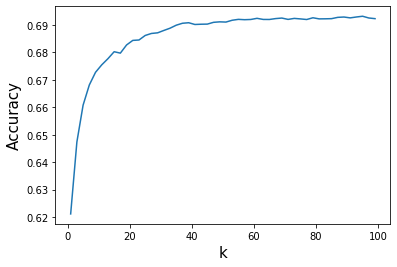

In [9]:
plt.plot(range(1, k_lim, 2), scores)
plt.ylabel("Accuracy", size=15)
plt.xlabel("k", size=15)

In [10]:
i = np.argmax(scores)
print(i*2+1, scores[i])

95 0.6931149046512884


### C. Decision tree and random forest<a name="dtrf"></a>

#### Decision tree

The first thing that strikes out after running tests with different features is that `category` (with label or one-hot encoding) remains the most relevant feature to increase accuracy (about 2% better).

Secondly, we noticed after fitting each single feature separately into a decision tree model is that not only is label encoding much faster than one-hot encoding (just 1 feature vs. many), but it provides similar accuracy. For this reason, most tests combining several features used label encoding. This is interesting because a decision tree might think there is an inherent hierarchy to the label-encoded category, even though that is not the case. It is also worth noting that, when using one-hot encoding, the line across the various levels of depth is more jagged, therefore suggesting that one-hot encoding's effectiveness is more subject to randomness. 

We also noticed that there is no significant difference in performance between the main criteria for picking attributes/thresholds, namely Gini and entropy (the latter seems slightly better).

Generally speaking, adding more features to the decision tree gives more accuracy. Our best results were achieved by keeping all 5 features (with standard or min-max normalization, and label-encoding). That being said, simply combining the `usd_goal_real` (MM) feature with `category` (LE) gave us an accuracy rivaling with the best score. This is consistent with what was observed for logistic regression, thus further increasing our belief that the goal and the category have good synergy, and that increasing the number of features increases accuracy, although the marginal increase of each feature is quite small.

Finally, as expected, normalizing the numerical data doesn't affect accuracy of the decision tree.

In [34]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="label",
                                                features=["goal", "time", "category", "main_category", "country"])

scores = []

for d in range(1, 20):
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RSEED)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X_test, y_test))

Text(0.5, 0, 'depth')

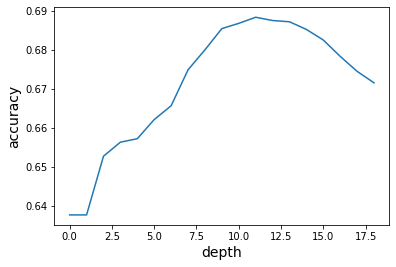

In [24]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('depth', fontsize=14)

In [25]:
i = np.argmax(scores)
print(i+1, scores[i])

12 0.6883204581059911


In [26]:
list(zip(X_train.columns, DT.feature_importances_))

[(0, 0.30997295627605603),
 (0, 0.4035138199256794),
 ('category', 0.15833297031875862),
 ('main_category', 0.0845817297310279),
 ('country', 0.043598523748477946)]

In [36]:
classification_report(y_test, DT.predict(X_test), output_dict=True)

{'0': {'precision': 0.718148557490758,
  'recall': 0.7981490109703926,
  'f1-score': 0.7560383566040764,
  'support': 47218},
 '1': {'precision': 0.5580543448020031,
  'recall': 0.4486319242525908,
  'f1-score': 0.49739626384526364,
  'support': 26826},
 'accuracy': 0.6715196369726109,
 'macro avg': {'precision': 0.6381014511463805,
  'recall': 0.6233904676114916,
  'f1-score': 0.62671731022467,
  'support': 74044},
 'weighted avg': {'precision': 0.6601467295291603,
  'recall': 0.6715196369726109,
  'f1-score': 0.6623328196213646,
  'support': 74044}}

#### Random forest

Random forests being quite intense in terms of computation, we didn't run all the tests done with decision trees (especially not the ones with one-hot encoding!). 

In [15]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="label",
                                                features=["goal", "time", "category", "main_category", "country"])

scores = []

for d in range(1,20):
    RF = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=d, random_state=RSEED)
    RF.fit(X_train, y_train)
    scores.append(RF.score(X_test, y_test))

Text(0.5, 0, 'depth')

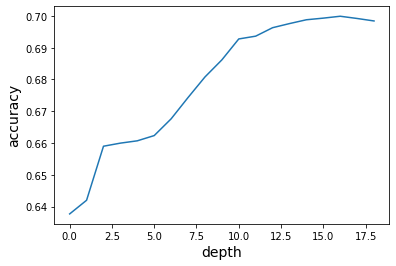

In [19]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('depth', fontsize=14)

In [20]:
i = np.argmax(scores)
print(i+1, scores[i])

17 0.6998946572308358


In [21]:
list(zip(X_train.columns, RF.feature_importances_))

[(0, 0.3183981709042826),
 (0, 0.3695623684755034),
 ('category', 0.16711572096760108),
 ('main_category', 0.09300941840496395),
 ('country', 0.05191432124764913)]

### D. Neural network<a name="nn"></a>

Highest: 67.12% with cat and maincat
adding country: 66.67

with numerical values it stays low.

all features: 67

In [28]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                features=["goal", "time", "category", "main_category", "country"])

Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

NN = Sequential()
NN.add(Dense(512, input_shape=(X_train.shape[1],)))
NN.add(Activation("relu"))
NN.add(Dropout(0.2))
NN.add(Dense(2))
NN.add(Activation("softmax"))

optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
NN.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               101888    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 102,914
Trainable params: 102,914
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_hist = NN.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_split=0.2)


Train on 236940 samples, validate on 59235 samples
Epoch 1/30
236940/236940 [==============================] - 15s 65us/step - loss: 0.6588 - accuracy: 0.6232 - val_loss: 0.6443 - val_accuracy: 0.6405
Epoch 2/30
236940/236940 [==============================] - 15s 64us/step - loss: 0.6430 - accuracy: 0.6354 - val_loss: 0.6348 - val_accuracy: 0.6405
Epoch 3/30
236940/236940 [==============================] - 15s 63us/step - loss: 0.6350 - accuracy: 0.6375 - val_loss: 0.6281 - val_accuracy: 0.6442
Epoch 4/30
236940/236940 [==============================] - 15s 64us/step - loss: 0.6293 - accuracy: 0.6429 - val_loss: 0.6229 - val_accuracy: 0.6496
Epoch 5/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6249 - accuracy: 0.6508 - val_loss: 0.6188 - val_accuracy: 0.6596
Epoch 6/30
236940/236940 [==============================] - 15s 62us/step - loss: 0.6214 - accuracy: 0.6573 - val_loss: 0.6156 - val_accuracy: 0.6658
Epoch 7/30
236940/236940 [======================

### E. Linear regression<a name="linr"></a>

## 4. Conclusion<a name="conclusion"></a>


Sadly, our dataset did not contain the project _descriptions_. Had it been the case, it would have been interesting to do some text analysis on them to predict success or failure. Indeed, we believe that, besides the video, the project description is a very important aspect of a Kickstarter project in terms of marketing, and it can have a far greater impact on the amount of money raised than, say, the category or the country.

In this sense, the categories we were working with were not very interesting, and it is not surprising to see that they did not significantly contribute to model accuracy, save for the specific category, perhaps.